In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras import regularizers

In [2]:
#[유저 번호, 레시피 번호, 해당 레시피에 대한 선호 여부] 형태의 임의의 데이터셋
#유저가 레시피를 본 적이 없어 선호 여부 데이터가 존재하지 않는 항목은 제외 ex) 2번 유저의 6번 레시피
data = [
        [1,1,1],
        [1,2,0],
        [1,3,1],
        [1,4,1],
        [1,5,0],
        [1,6,0],
        [1,7,0],
        [1,8,0],
        [1,9,0],
        [1,10,0],
        [2,1,0],
        [2,2,1],
        [2,3,0],
        [2,4,0],
        [2,5,1],
        [2,7,0],
        [2,8,0],
        [2,9,0],
        [2,10,1],
        [3,1,1],
        [3,3,1],
        [3,4,1],
        [3,5,1],
        [3,6,0],
        [3,7,1],
        [3,8,0],
        [3,9,0],
        [3,10,0],
        [4,1,0],
        [4,2,1],
        [4,3,0],
        [4,4,0],
        [4,5,1],
        [4,6,1],
        [4,7,0],
        [4,8,1],
        [4,9,0],
        [4,10,1],
        [5,1,1],
        [5,2,1],
        [5,3,0],
        [5,5,0],
        [5,6,0],
        [5,7,0],
        [5,8,0],
        [5,9,1],
        [5,10,0],
        [6,1,1],
        [6,2,0],
        [6,3,1],
        [6,4,0],
        [6,5,1],
        [6,7,1],
        [6,8,1],
        [6,9,0],
        [6,10,0],
        [7,1,0],
        [7,2,0],
        [7,3,0],
        [7,4,1],
        [7,5,1],
        [7,6,0],
        [7,7,1],
        [7,8,0],
        [7,9,1],
        [7,10,1],
        [8,2,1],
        [8,3,0],
        [8,4,0],
        [8,6,1],
        [8,7,0],
        [8,8,1],
        [8,9,0],
        [8,10,0],
        [9,1,0],
        [9,3,0],
        [9,4,1],
        [9,5,0],
        [9,6,0],
        [9,7,0],
        [9,8,1],
        [9,9,0],
        [9,10,0],
        [10,1,1],
        [10,2,0],
        [10,3,0],
        [10,4,0],
        [10,5,1],
        [10,6,1],
        [10,7,0],
        [10,8,1],
        [10,10,1],
        [11,1,1],
        [11,2,1],
        [11,3,1],
        [11,4,0],
        [11,5,0],
        [11,6,1],
        [11,7,1],
        [11,8,1],
        [11,9,1],
        [11,10,1],
        [12,1,0],
        [12,5,1],
        [12,7,1],
        [12,8,1],
        [13,1,0],
        [13,2,0],
        [13,3,0],
        [13,4,0],
        [13,5,1],
        [13,6,0],
        [13,7,1],
        [13,9,0],
        [13,10,1],
        [14,1,1],
        [14,3,0],
        [14,4,0],
        [14,6,1],
        [14,7,1],
        [14,8,0],
        [14,9,1],
        [14,10,1]
]

#pandas DataFrame으로 적용
df = pd.DataFrame(data = data, columns = ['user','item','rating'])
df_table = pd.pivot_table(df, values='rating', index='item', columns='user', fill_value='')

df

,user,item,rating
0,1,1,1
1,1,2,0
2,1,3,1
3,1,4,1
4,1,5,0
...,...,...,...
118,14,6,1
119,14,7,1
120,14,8,0
121,14,9,1


In [3]:
users = df.user.unique() #0~13 (총 14)
items = df.item.unique() #0~9 (총 10)

#기존의 1부터 시작하던 유저 번호, 레시피 번호의 column값을 0부터 시작하도록 조정
userid2idx = {o:i for i,o in enumerate(users)}
itemid2idx = {o:i for i,o in enumerate(items)}

df['user'] = df['user'].apply(lambda x: userid2idx[x])
df['item'] = df['item'].apply(lambda x: itemid2idx[x])

df

,user,item,rating
0,0,0,1
1,0,1,0
2,0,2,1
3,0,3,1
4,0,4,0
...,...,...,...
118,13,5,1
119,13,6,1
120,13,7,0
121,13,8,1


In [4]:
#데이터셋의 데이터를 훈련용 데이터(8할)와 테스트용 데이터(2할)로 분리
split = np.random.rand(len(df)) < 0.8

train_df = df[split]
test_df = df[~split]

print(train_df.shape)
print(test_df.shape)

(97, 3)
(26, 3)


In [5]:
#임베딩: 잠재 인수(latend factor)의 모양을 정의하고 모델에 삽입
#임베딩된 값들은 모델 훈련을 통해 최적의 값으로 학습이 됨
n_items = len(df.item.unique())
n_users = len(df.user.unique())
n_latent_factors = 64

item_input = Input(shape=[1])
# Item latent factor
item_embedding = Embedding(n_items, n_latent_factors,
                            embeddings_regularizer=regularizers.l2(0.00001), 
                            name='item_embedding')(item_input)

user_input = Input(shape=[1])
# User latent factor
user_embedding = Embedding(n_users, n_latent_factors,
                           embeddings_regularizer=regularizers.l2(0.00001),
                           name='user_embedding')(user_input)

In [6]:
#벡터화
#잠재 벡터(latent vector): 2D로 되어있는 임베딩을 1D로 변환

# Item latent vector
item_vec = Flatten()(item_embedding)
# User latent vector
user_vec = Flatten()(user_embedding)

In [7]:
#모델링
r_hat = dot([item_vec, user_vec], axes=-1)
model = Model([user_input, item_input], r_hat)
#최적화(optimizer): adam / 손실함수(loss function): 평균 제곱 오차
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

train loss:  0.00038042038795538247


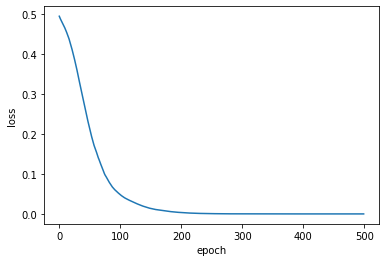

In [8]:
#모델 훈련
#batch_size와 epochs 값 조정 필요
hist = model.fit([train_df.user, train_df.item], train_df.rating, epochs=500, verbose=0 ) 

print('train loss: ', hist.history['loss'][-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [9]:
#모델 평가
test_loss = model.evaluate([test_df.user, test_df.item], test_df.rating)
print('test loss: ', test_loss)

1/1 [==============================] - 0s 124ms/step - loss: 0.2544
test loss:  0.2544017732143402


In [10]:
Q = model.get_layer(name='item_embedding').get_weights()[0]
P = model.get_layer(name='user_embedding').get_weights()[0]
P_t = np.transpose(P)

R_hat = np.dot(Q, P_t)
pd.set_option('display.float_format','{:.2f}'.format)
#학습된 모델이 예측한 데이터셋
pd.DataFrame(R_hat)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.00,-0.09,1.00,0.00,1.00,0.63,0.00,0.35,-0.00,1.00,1.00,0.19,-0.00,1.00
1,0.00,1.00,0.12,0.68,1.00,0.72,0.00,1.00,0.25,0.78,1.00,0.95,-0.00,0.09
2,0.32,0.06,1.00,0.00,0.00,1.00,0.61,0.00,0.40,0.00,1.00,0.34,0.00,0.00
3,1.00,-0.11,1.00,-0.00,-0.01,0.00,1.00,-0.00,1.00,0.00,0.00,-0.06,0.00,0.00
4,0.00,1.00,1.00,0.18,-0.23,1.00,0.35,0.06,0.00,-0.03,0.00,1.00,1.00,0.18
5,0.00,0.08,-0.00,1.00,-0.00,0.35,-0.00,1.00,0.00,1.00,1.00,0.54,0.00,1.00
6,0.00,0.00,1.00,0.00,-0.00,1.00,1.00,0.00,-0.02,0.36,1.00,0.49,1.00,1.00
7,0.00,-0.00,0.00,1.00,0.16,1.00,0.00,1.00,1.00,1.00,1.00,1.00,-0.19,-0.00
8,0.27,-0.00,0.00,-0.00,1.00,-0.00,1.00,0.00,0.00,0.39,1.00,0.01,0.00,0.29
9,0.05,1.00,0.51,1.00,0.00,0.00,1.00,0.51,-0.00,0.47,1.00,0.90,1.00,0.61


In [11]:
#실제 데이터셋
df_table

user,1,2,3,4,5,6,7,8,9,10,11,12,13,14
item,,,,,,,,,,,,,,
1,1.00,0.00,1.00,0.00,1.00,1.00,0.00,,0.00,1.00,1.00,0.00,0.00,1.00
2,0.00,1.00,,1.00,1.00,0.00,0.00,1.00,,0.00,1.00,,0.00,
3,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,,0.00,0.00
4,1.00,0.00,1.00,0.00,,0.00,1.00,0.00,1.00,0.00,0.00,,0.00,0.00
5,0.00,1.00,1.00,1.00,0.00,1.00,1.00,,0.00,1.00,0.00,1.00,1.00,
6,0.00,,0.00,1.00,0.00,,0.00,1.00,0.00,1.00,1.00,,0.00,1.00
7,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00
8,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,,0.00
9,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,,1.00,,0.00,1.00
